In [38]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)


# print(os.getcwd())

In [39]:
def find_cluster(point):
    return np.argmin([np.linalg.norm(point - center_list[i]) for i in range(len_cluster)])

def find_cluster_matrix(matrix):
    return np.array(list(map(find_cluster, matrix)))


# read pickle
with open('output/X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('output/X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    

with open('output/explainer.pkl', 'rb') as handle:
    explainer = pickle.load(handle)

with open('output/shap_values.pkl', 'rb') as handle:
    shap_values = pickle.load(handle)
    
    


In [40]:
shap_values_np = np.array(shap_values)
shap.initjs()

In [41]:
shap_values_np.shape

(9, 150, 23)

# Show feature importance for each feature of each class 

In [58]:
len_cluster = 9
feature_cols = ['CPU1TempTemperatureReading-TemperatureReading', 'CPU2TempTemperatureReading-TemperatureReading', 'CUPSSystemUsage-CPUUsage', 'CUPSSystemUsage-IOUsage', 'CUPSSystemUsage-MemoryUsage', 'CUPSSystemUsage-SystemUsage', 'DIMMSocketA1TemperatureReading-TemperatureReading', 'DIMMSocketA2TemperatureReading-TemperatureReading', 'DIMMSocketA3TemperatureReading-TemperatureReading', 'DIMMSocketA4TemperatureReading-TemperatureReading', 'DIMMSocketA5TemperatureReading-TemperatureReading', 'DIMMSocketA6TemperatureReading-TemperatureReading', 'Fan1RPMReading-RPMReading', 'Fan2RPMReading-RPMReading', 'Fan3RPMReading-RPMReading', 'Fan4RPMReading-RPMReading', 'Fan5RPMReading-RPMReading', 'Fan6RPMReading-RPMReading', 'PowerMetricsTotalStoragePower-SystemPowerConsumption', 'PowerMetricsTotalStoragePower-TotalCPUPower', 'PowerMetricsTotalStoragePower-TotalMemoryPower', 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio', 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower']



In [59]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

,feature_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,DIMMSocketA6TemperatureReading-TemperatureReading,0.549234,0.315293,0.297543,0.345175,0.684410,0.741834,1.219785,0.704984,0.429497
1,CUPSSystemUsage-SystemUsage,0.358072,0.232991,0.216189,0.340928,0.464291,0.757047,0.591626,0.119359,0.062002
2,CPU2TempTemperatureReading-TemperatureReading,0.374577,0.243452,0.214208,0.385719,0.505736,0.133845,0.262316,0.135399,0.082377
3,CPU1TempTemperatureReading-TemperatureReading,1.393702,0.460977,0.261010,0.267077,0.480529,0.695919,0.844300,0.674895,0.652621
4,DIMMSocketA1TemperatureReading-TemperatureReading,0.394030,0.713209,0.365357,0.125992,0.066570,0.061534,0.113900,0.088377,0.089367
5,ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower,0.205989,0.116589,0.114456,0.234244,0.342781,0.879509,0.568827,0.241636,0.139018
6,CUPSSystemUsage-MemoryUsage,0.848455,0.485166,0.112591,0.101687,0.217428,0.351736,0.650752,0.450368,0.153618
7,Fan2RPMReading-RPMReading,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Fan3RPMReading-RPMReading,0.971625,0.702616,0.365137,0.290607,0.283651,0.306489,0.675529,0.475115,0.723895
9,CUPSSystemUsage-CPUUsage,1.034378,0.503431,0.402081,0.396090,0.619969,0.688162,0.935946,0.687444,0.648947


In [60]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

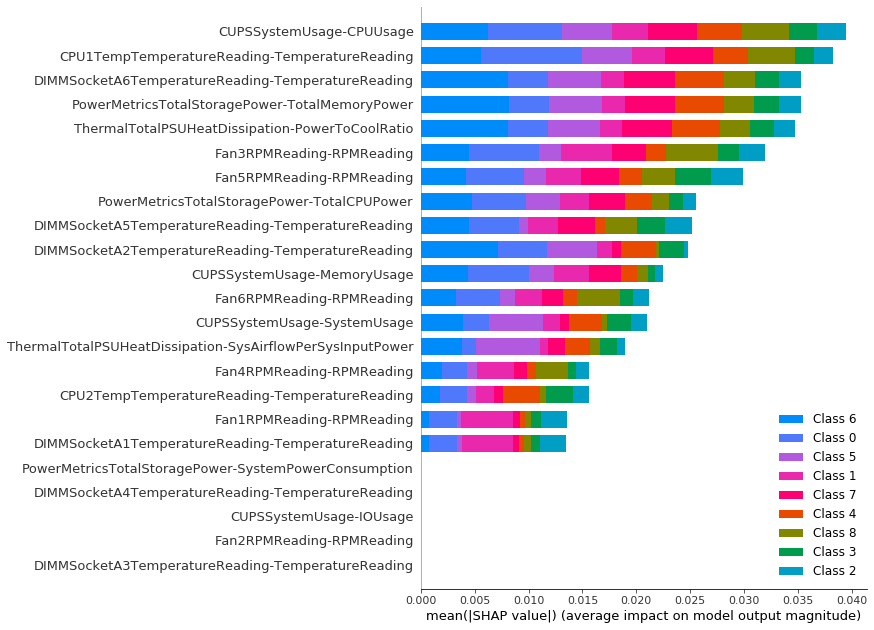

In [61]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)

cluster 0


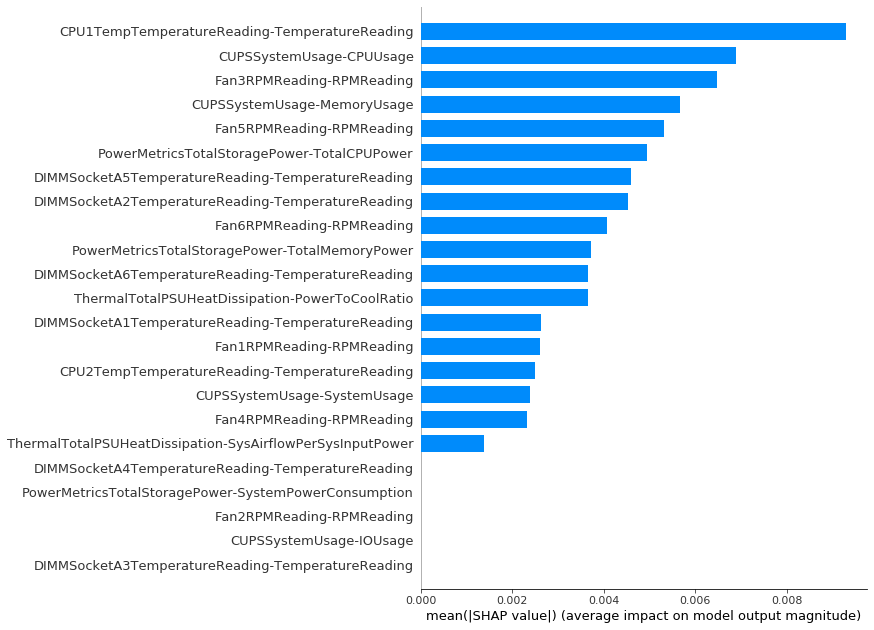



cluster 1


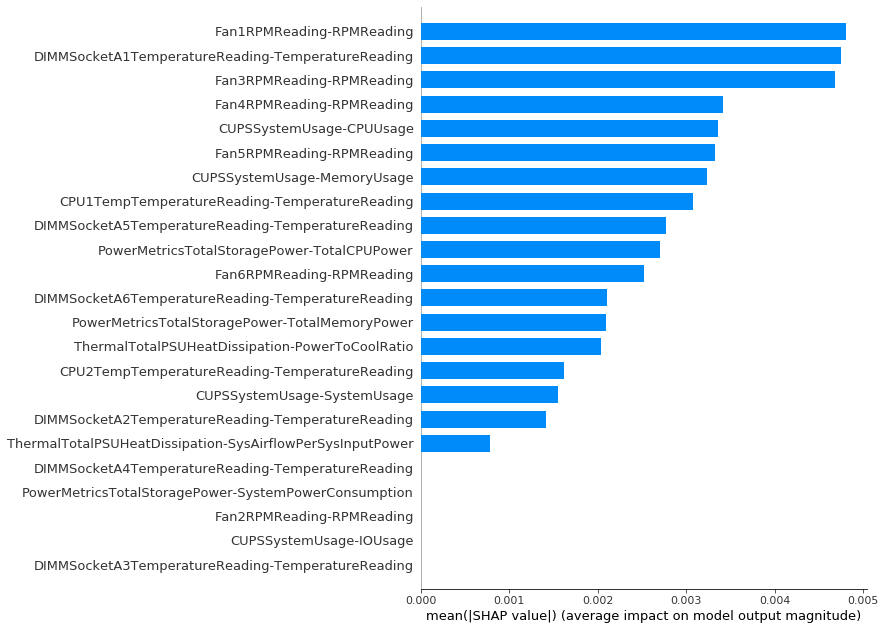



cluster 2


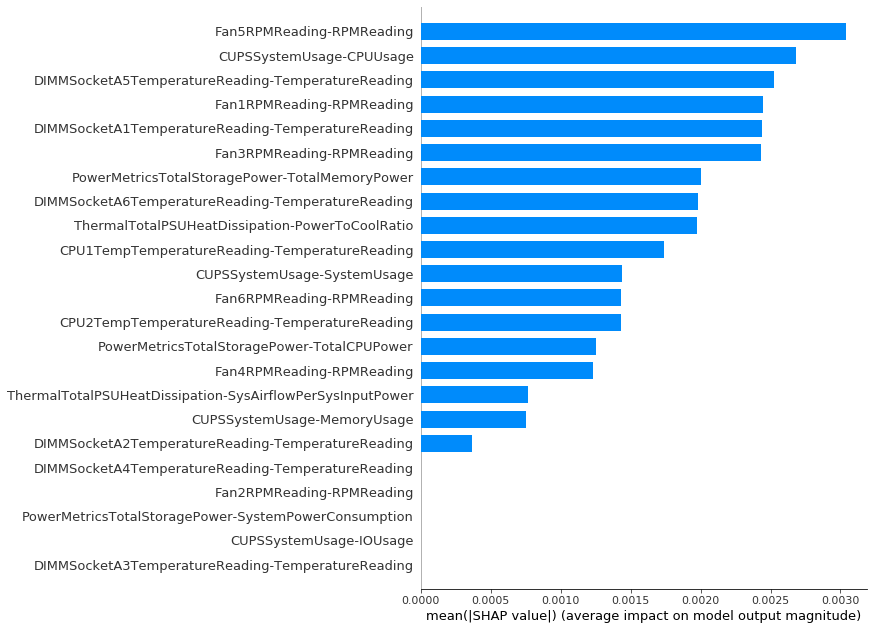



cluster 3


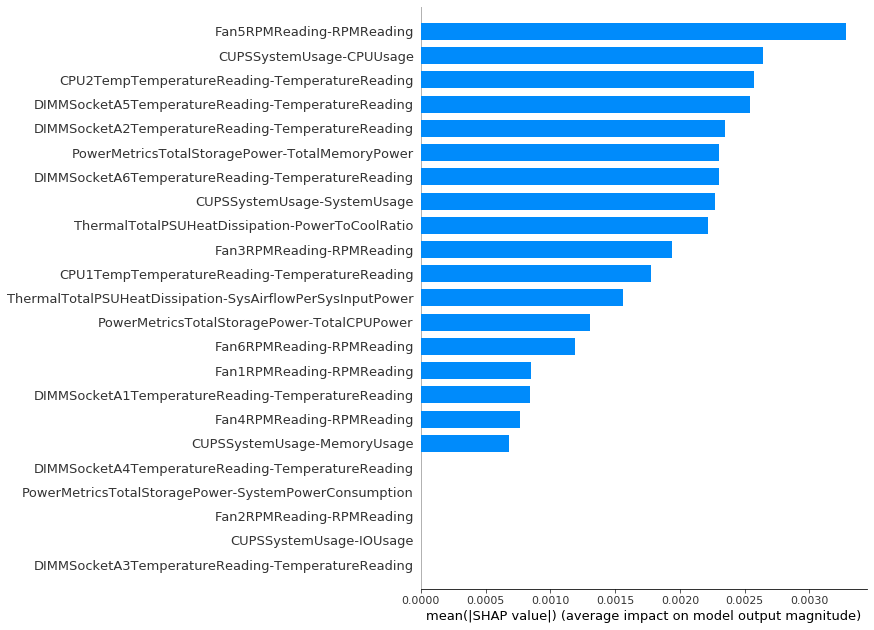



cluster 4


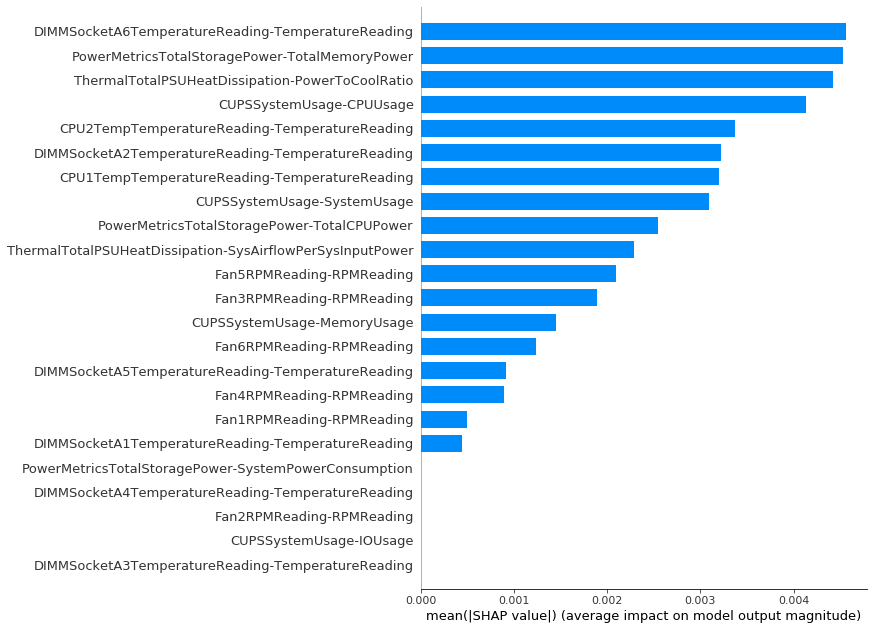



cluster 5


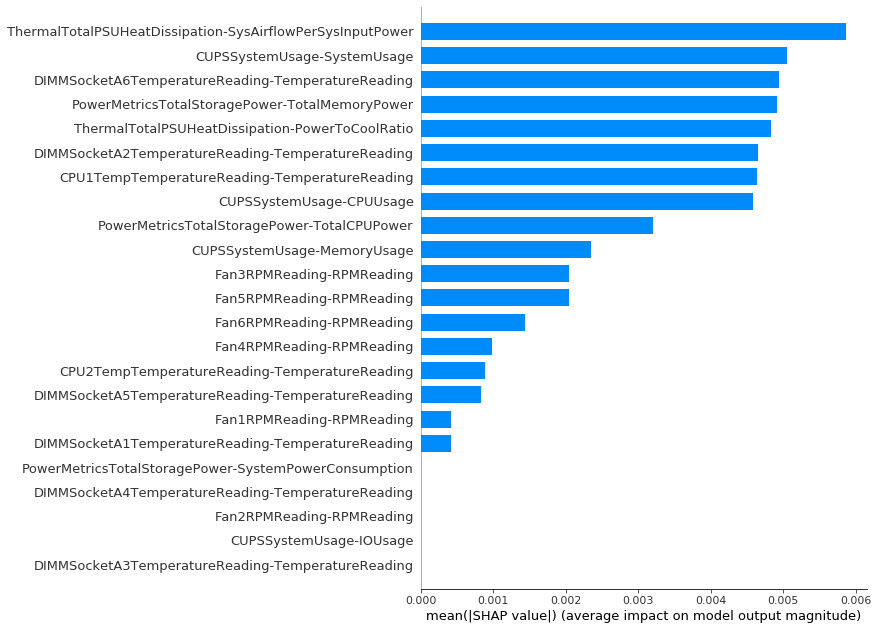



cluster 6


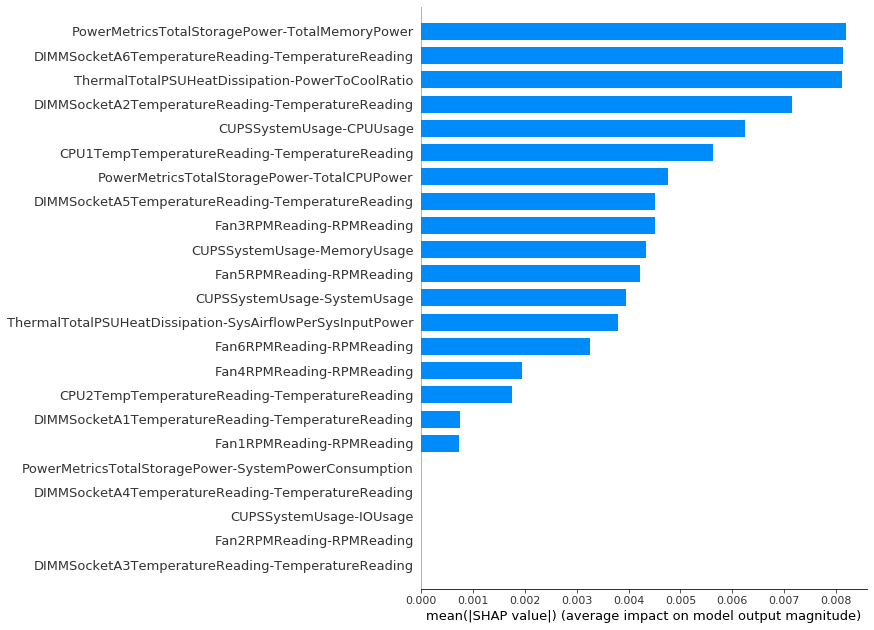



cluster 7


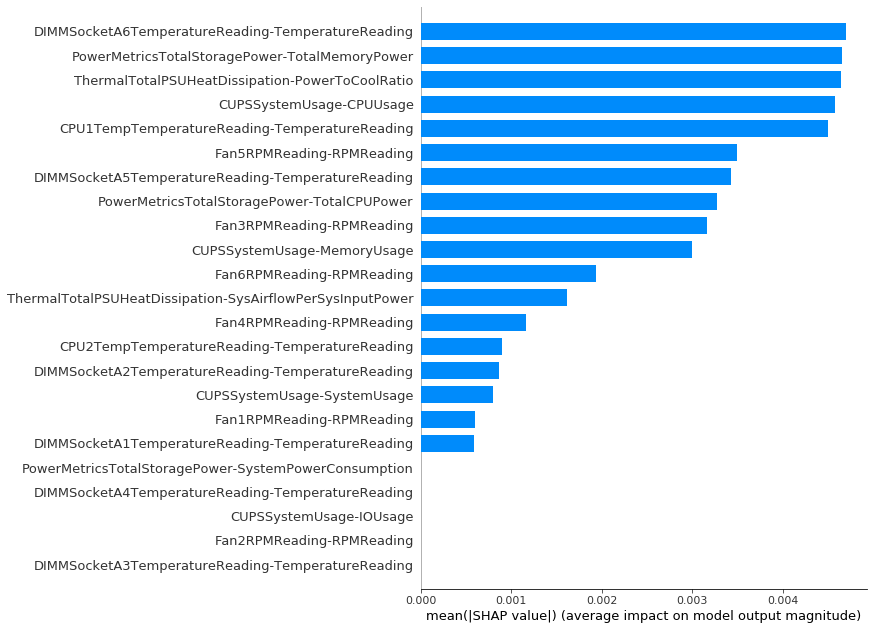



cluster 8


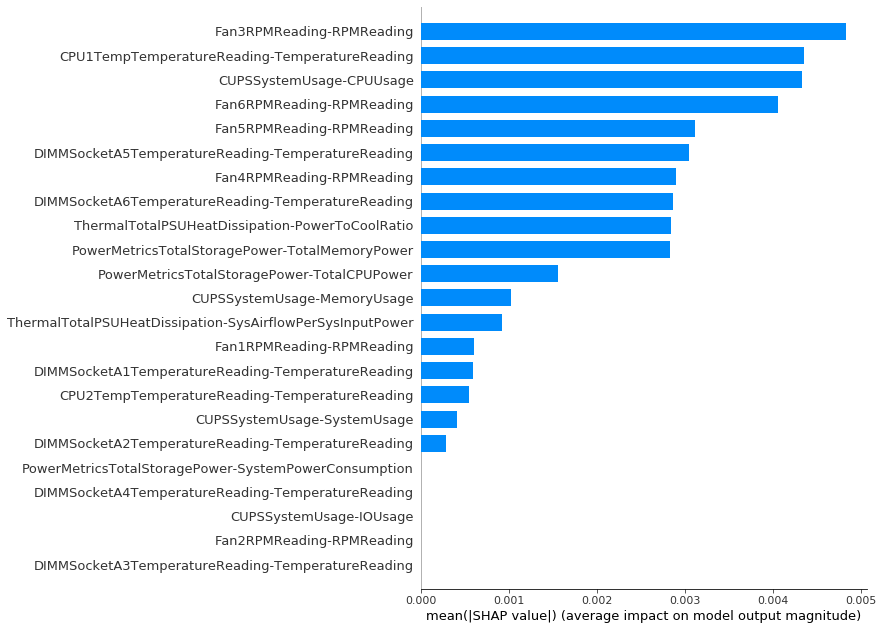

In [62]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [63]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

In [64]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name=f"cluster {i}", mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


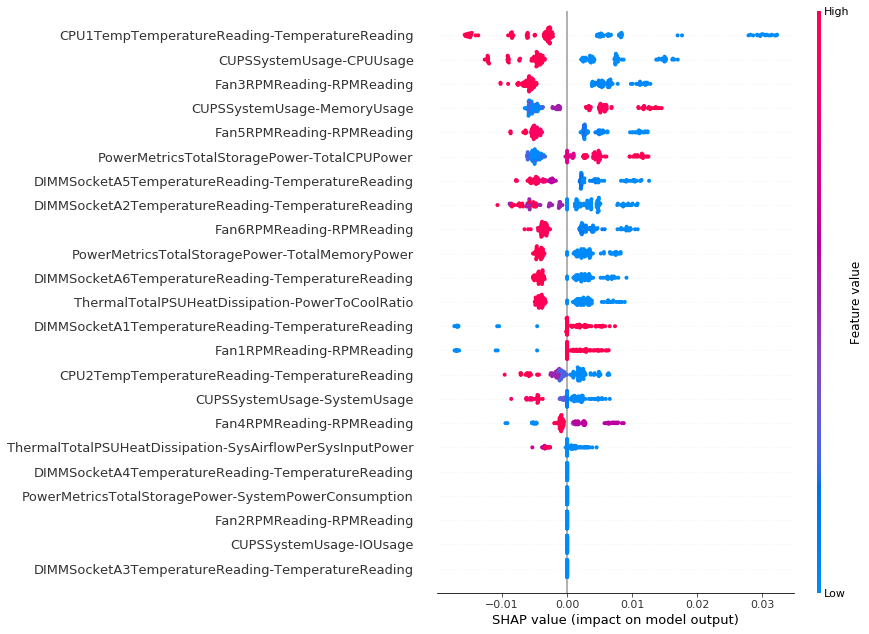



cluster 1


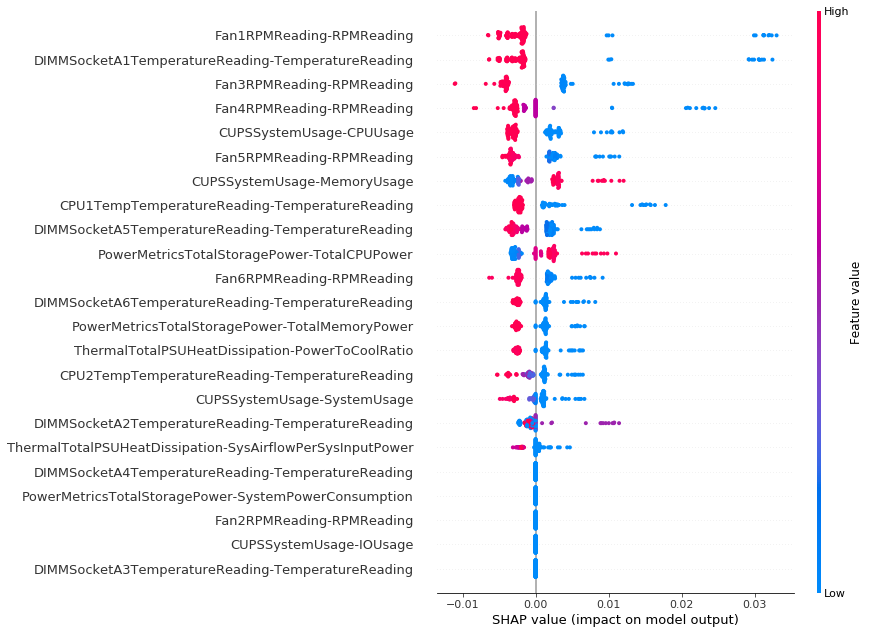



cluster 2


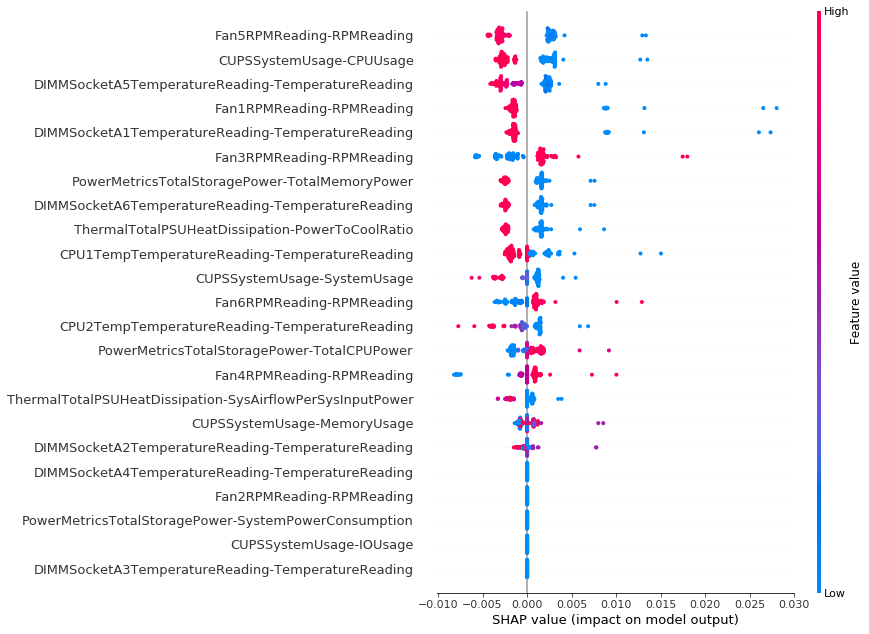



cluster 3


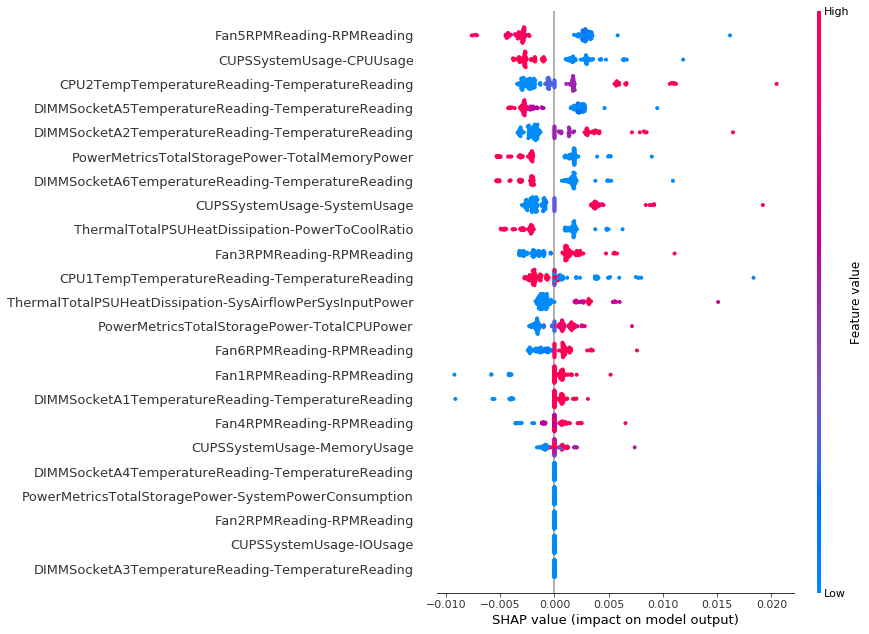



cluster 4


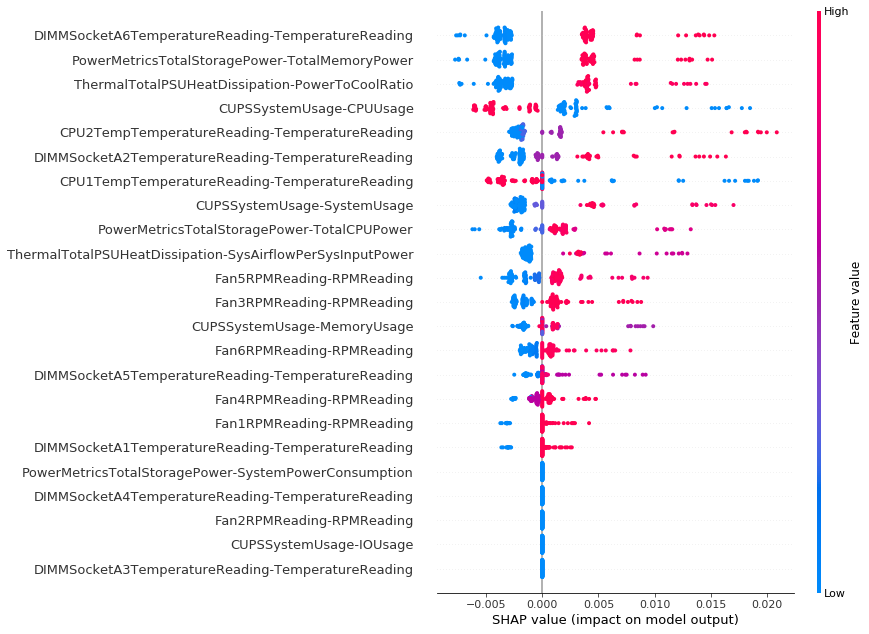



cluster 5


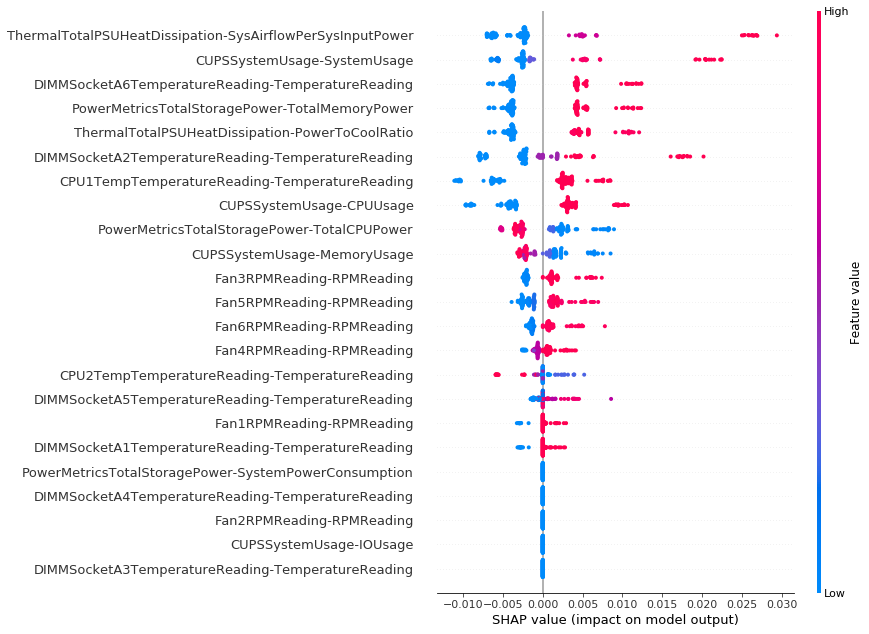



cluster 6


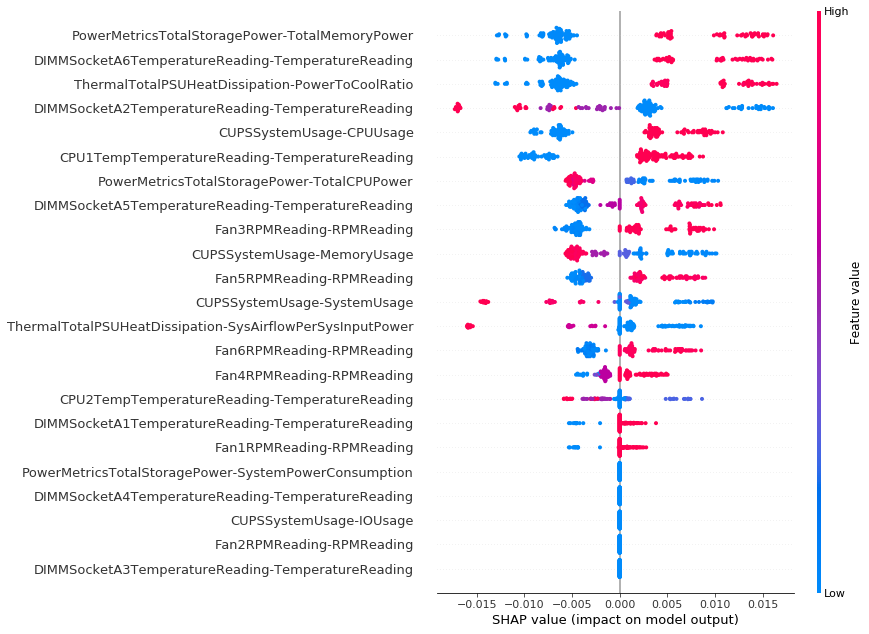



cluster 7


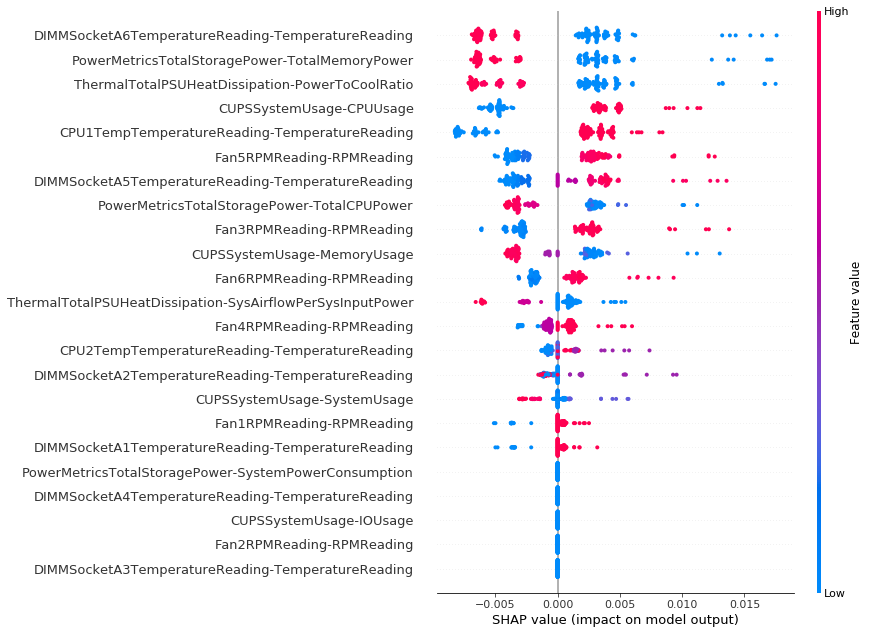



cluster 8


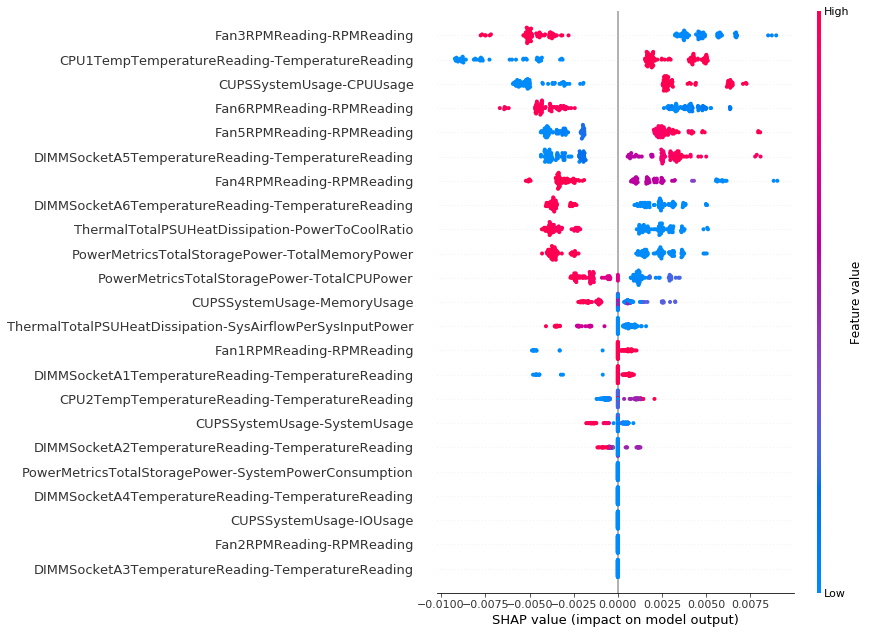

In [65]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display = len(feature_cols), show=False, plot_type = "dot", feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")